In [38]:
import pandas as pd
import numpy as np
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
import matplotlib.pyplot as plt
from IPython import display 
import scipy

import pickle
import dask

In [39]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 16)
client = Client(cluster)
client

/opt/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:37281 Dashboard: http://127.0.0.1:43459/status,Cluster Workers: 16 Cores: 16 Memory: 67.31 GB


In [40]:
#Load Data
with open("sweep-000m005-010p000_trim.pkl", "rb") as f:
    ra_dec = pickle.load(f)

In [41]:
#Basic cuts and conversion to radians
#ra_dec = dd.from_pandas(ra_dec0)
ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.z_phot_median>0.01)]
ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]

#Oversampling
oversample = 1
gauss = ra_dec.sample(n = int(oversample*len(ra_dec)), replace = True)
random1 = np.random.normal(loc = 0, scale = 1, size = int(oversample*len(ra_dec)))
gauss["z_phot_median"] = gauss["z_phot_median"] + random1*gauss["z_phot_std"]

#Binning by redshift
bins = np.arange(0.1, ra_dec.z_phot_median.max(), 0.01)
binned = [ra_dec[np.logical_and(ra_dec.z_phot_median>=i-.03, ra_dec.z_phot_median<=i+.03)] for i in bins]
bins_g = np.arange(0.1, ra_dec.z_phot_median.max(), 0.01)
binned_g = [gauss[np.logical_and(gauss.z_phot_median>=i-.03, gauss.z_phot_median<=i+.03)] for i in bins]

#Cartesian coordinates
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
for i in range(0, len(binned)):
    mean = binned[i].z_phot_median.mean()
    binned[i]["z"] = cos.comoving_distance(mean)*np.ones(len(binned[i]))
    binned[i]["y"] = cos.comoving_distance(mean)*binned[i]["DEC_r"]
    binned[i]["x"] = cos.comoving_distance(mean)*binned[i]["RA_r"]*np.cos(binned[i]["DEC_r"])
for i in range(0, len(binned_g)):
    mean = binned_g[i].z_phot_median.mean()
    binned_g[i]["z"] = cos.comoving_distance(mean)*np.ones(len(binned_g[i]))
    binned_g[i]["y"] = cos.comoving_distance(mean)*binned_g[i]["DEC_r"]
    binned_g[i]["x"] = cos.comoving_distance(mean)*binned_g[i]["RA_r"]*np.cos(binned_g[i]["DEC_r"])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [20]:
def clusters_dist(binned, binned_g, b):
    sample_real = binned[b]
    massive_sample = sample_real[sample_real.mass>11]
    if len(massive_sample)>0:
        massive_tree = spatial.cKDTree(massive_sample[["x", "y"]])
        sample = binned_g[b]
        tree = spatial.cKDTree(sample[["x", "y"]])
        
        r = 2
        neighbors = massive_tree.query_ball_tree(tree, r)
        counts = np.array([])
        for i in range(0, len(neighbors)):
            counts = np.append(counts, len(neighbors[i]))
        
        sample.reset_index(inplace=True)
        massive_sample.reset_index(inplace=True)
        massive_sample["neighbor_numbers"] = pd.Series(neighbors)
        massive_sample["neighbors"] = pd.Series(counts)
        
        masses = 10**sample.mass
        massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["neighbor_mass"][i] = np.log10(np.sum(masses[massive_sample.neighbor_numbers[i]]))
        
        reds = sample.z_phot_median
        massive_sample["mean_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["mean_red"][i] = np.mean(reds[massive_sample.neighbor_numbers[i]])
        
        massive_sample["med_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["med_red"][i] = np.median(reds[massive_sample.neighbor_numbers[i]])
            
        clusters = massive_sample[massive_sample.neighbors>5]
        
        if len(clusters)>0:
            cluster_tree = spatial.cKDTree(clusters[["x", "y"]])
            cluster_tree2 = spatial.cKDTree(clusters[["x", "y"]].copy())
            r = 2
            neighbors_c = cluster_tree.query_ball_tree(cluster_tree2, r)
            clusters.reset_index(inplace= True)
            clusters.drop(columns = ["neighbor_numbers"])
            clusters["neighbor_numbers"] = pd.Series(neighbors_c)
            
            clusters.sort_values("mass", inplace = True)
            clusters["ncluster"] = np.zeros(len(clusters))
            sample["ncluster"] = np.zeros(len(sample))
            clusternum = 1
            
            for index, gal in clusters.iterrows():
                if gal.ncluster == 0:
                    gal.ncluster = clusternum
                    for index2 in gal.neighbor_numbers:
                        if clusters.at[index2, "ncluster"] == 0:
                            clusters.at[index2, "ncluster"] = clusternum
                    clusternum+=1
            
            most_massive = clusters.sort_values(by = ['ncluster','mass'], ascending = False).groupby('ncluster').head(1)
        else:
            most_massive = pd.DataFrame([[]])
            
    else:
        clusters = pd.DataFrame([[]])
        most_massive = pd.DataFrame([[]])
        counts = np.array([0])
    return len(clusters), len(most_massive), np.median(counts)

In [21]:
dist_clusters = []
dist_most_massive = []
median_gal = []
pbar = display.ProgressBar(len(binned))
pbar.display()
for b in range(0, len(binned), 20):
    pbar.progress = b
    values = clusters_dist(binned, binned_g, b)
    dist_clusters.append(values[0])
    dist_most_massive.append(values[1])
    median_gal.append(values[2])
    print(b)

[===============                                             ] 60/233

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

20


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


40


KeyboardInterrupt: 

In [ ]:
redshift = np.arange(0, len(binned), 20)
a = 1.5
b = 1.7
z0 = 0.7
r = (redshift/100)/z0
plt.plot(redshift, median_gal)
plt.show()
plt.plot(redshift, dist_clusters)
plt.plot(redshift, (50000)*(r**a)*(np.e**-r)**b)
plt.show()
plt.plot(redshift, dist_most_massive)
plt.plot(redshift, (5000)*(r**a)*(np.e**-r)**b)
plt.show()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting

In [ ]:
print(redshift)
print(dist_clusters)
print(dist_most_massive)
print((r**a)*(np.e**-(r**b)))

In [42]:
sample_real = binned[40]
massive_sample = sample_real[sample_real.mass>11]
if len(massive_sample)>0:
    massive_tree = spatial.cKDTree(massive_sample[["x", "y"]], copy_data = True)
    sample = binned_g[40]
    tree = spatial.cKDTree(sample[["x", "y"]], copy_data = True)
    
    neighbors = massive_tree.query_ball_tree(tree, 2)
    neighbor = pd.DataFrame(neighbors)
    counts = np.array([])
    for i in range(0, len(neighbors)):
        counts = np.append(counts, len(neighbors[i]))
        
    sample.reset_index(inplace=True)
    massive_sample.reset_index(inplace=True)
    massive_sample["neighbor_numbers"] = pd.Series(neighbors)
    massive_sample["neighbors"] = pd.Series(counts)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
massive_sample.head()

,index,z_phot_median,z_phot_std,mass,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,...,FLUX_Z,FLUX_W1,MASKBITS,RA_r,DEC_r,z,y,x,neighbor_numbers,neighbors
0,845,0.495838,0.020928,11.069395,8000,328953,0063m002,913,DEV,6.254628,...,14.274906,28.359779,0,0.109164,-0.005989,1896.630444,-11.358340,207.039783,"[839, 2528, 5645, 8606, 11968, 12378, 16923, 1...",12.0
1,1677,0.497664,0.075233,11.071216,8000,328953,0063m002,1753,DEV,6.281819,...,20.189161,44.844925,0,0.109638,-0.005475,1896.630444,-10.384462,207.940452,"[2528, 8606, 11929, 11968, 16923, 19447, 28697...",8.0
2,1919,0.474547,0.031248,11.005792,8000,328953,0063m002,2006,DEV,6.278695,...,13.359476,23.123840,0,0.109584,-0.005303,1896.630444,-10.057061,207.837239,"[2528, 8606, 11929, 11968, 16923, 19447, 28697...",8.0
3,4104,0.483174,0.016295,11.226141,8000,328953,0063m002,4229,DEV,6.329985,...,20.095455,42.041519,0,0.110479,-0.003959,1896.630444,-7.508725,209.536347,"[4433, 10111, 11929, 19447, 24385, 27551]",6.0
4,5552,0.481948,0.015568,11.258733,8000,328953,0063m002,5689,DEV,6.491607,...,22.229078,47.063213,0,0.113300,-0.003061,1896.630444,-5.805929,214.887062,"[14406, 19766, 21404, 30669, 31913, 34798]",6.0


In [44]:
@dask.delayed
def mclusters(binned, binned_g, C = 2.5, r = 2):
    sample_real = binned
    massive_sample = sample_real[sample_real.mass>11]
    if len(massive_sample)>0:
        massive_tree = spatial.cKDTree(massive_sample[["x", "y"]], copy_data = True)
        sample = binned_g
        tree = spatial.cKDTree(sample[["x", "y"]], copy_data = True)
        
        neighbors = massive_tree.query_ball_tree(tree, r)
        counts = np.array([])
        for i in range(0, len(neighbors)):
            counts = np.append(counts, len(neighbors[i]))
        
        sample.reset_index(inplace=True)
        massive_sample.reset_index(inplace=True)
        massive_sample["neighbor_numbers"] = pd.Series(neighbors)
        massive_sample["neighbors"] = pd.Series(counts)
        
        masses = 10**sample.mass
        massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["neighbor_mass"][i] = np.log10(np.sum(masses[massive_sample.neighbor_numbers[i]]))
        
        reds = sample.z_phot_median
        massive_sample["mean_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["mean_red"][i] = np.mean(reds[massive_sample.neighbor_numbers[i]])
        
        massive_sample["med_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["med_red"][i] = np.median(reds[massive_sample.neighbor_numbers[i]])
            
        threshold = C*np.median(counts)
        clusters = massive_sample[massive_sample.neighbors>=threshold]
        
        if len(clusters)>0:
            cluster_tree = spatial.cKDTree(clusters[["x", "y"]])
            cluster_tree2 = spatial.cKDTree(clusters[["x", "y"]].copy())
            neighbors_c = cluster_tree.query_ball_tree(cluster_tree2, r)
            clusters.reset_index(inplace= True)
            clusters["cluster_neighbor_numbers"] = pd.Series(neighbors_c) #Neighboring galaxies with neighbors>threshold
            
            clusters.sort_values("mass", inplace = True)
            clusters["ncluster"] = np.zeros(len(clusters))
            clusternum = 1
            
            for index, gal in clusters.iterrows():
                if gal.ncluster == 0:
                    gal.ncluster = clusternum
                    for index2 in gal.cluster_neighbor_numbers:
                        if clusters.at[index2, "ncluster"] == 0:
                            clusters.at[index2, "ncluster"] = clusternum
                    clusternum+=1
            
            cluster_center = clusters.sort_values(by = ['ncluster','mass'], ascending = False).groupby('ncluster').head(1)
        else:
            cluster_center = pd.DataFrame([[]])
            
    else:
        clusters = pd.DataFrame([[]])
        cluster_center = pd.DataFrame([[]])
    
    return cluster_center

In [45]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b])
    delayed_results.append(delayed_result)


In [46]:
results = dask.compute(*delayed_results)

In [47]:
cluster_centrals = pd.DataFrame()
for i in range(len(results)):
    cluster_centrals = pd.concat([cluster_centrals, results[i]])

In [48]:
cluster_centrals.head()

,level_0,index,z_phot_median,z_phot_std,mass,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,...,z,y,x,neighbor_numbers,neighbors,neighbor_mass,mean_red,med_red,cluster_neighbor_numbers,ncluster
13,916,4854956,0.101657,0.004845,11.378450,8000,324629,0053m010,7371,DEV,...,427.761224,-6.536771,40.509453,"[97, 169, 183, 365, 428, 546, 578, 827, 849, 8...",169.0,12.631951,0.100326,0.101382,"[9, 10, 13, 14, 15]",6.0
12,881,4634093,0.119718,0.009279,11.223839,8000,321751,0058m015,472,COMP,...,427.761224,-12.025976,44.525179,"[429, 498, 510, 559, 564, 574, 791, 855, 861, ...",158.0,12.737308,0.100532,0.099520,"[11, 12]",2.0
5,480,2718419,0.071461,0.077887,11.814270,8000,318882,0086m020,729,DEV,...,427.761224,-15.563184,63.874359,"[5, 52, 101, 167, 219, 245, 254, 316, 341, 431...",186.0,12.728440,0.099133,0.098816,"[0, 1, 2, 3, 4, 5, 6, 7, 8]",1.0
4,712,4854956,0.101657,0.004845,11.378450,8000,324629,0053m010,7371,DEV,...,464.193661,-7.093508,43.959645,"[171, 186, 384, 579, 613, 792, 893, 914, 939, ...",142.0,12.592592,0.110587,0.109357,"[2, 4, 5, 6]",3.0
0,356,2718953,0.115112,0.007691,11.192059,8000,318882,0086m020,1272,DEV,...,464.193661,-16.877260,70.335909,"[5, 117, 164, 169, 226, 258, 318, 334, 353, 47...",156.0,12.820789,0.109217,0.109940,"[0, 1]",2.0


In [69]:
cluster_centrals["mean_red_z"] = cos.comoving_distance(cluster_centrals["mean_red"])

In [70]:
dz = 0.1
cluster_centrals["mean_red_z_scaled"] = cluster_centrals["mean_red_z"]*(2/(dz*cos.hubble_distance*cos.inv_efunc(cluster_centrals["mean_red"])))

In [71]:
cluster_centrals.head()

,level_0,index,z_phot_median,z_phot_std,mass,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,...,neighbors,neighbor_mass,mean_red,med_red,cluster_neighbor_numbers,ncluster,mean_red_z,mean_red_z_scaled,cluster_neighbor_numbers_3D,ncluster_3D
0,3661,2856284,0.546738,0.051599,11.000157,8000,317445,0093m022,789,EXP,...,18.0,12.426214,0.571653,0.573058,[183],1.0,2129.862928,13.434018,[0],1.0
1,148,191911,0.442124,0.028624,11.005227,8000,303050,0061m047,986,DEV,...,30.0,12.275995,0.441688,0.440975,[1],3.0,1701.907816,9.961646,[1],2.0
2,156,191911,0.442124,0.028624,11.005227,8000,303050,0061m047,986,DEV,...,32.0,12.316309,0.449424,0.449049,[3],2.0,1728.285434,10.160602,[2],3.0
3,5799,4603365,0.564786,0.047239,11.005846,8000,328949,0053m002,5664,REX,...,15.0,12.152242,0.587467,0.587523,[299],3.0,2179.776666,13.875829,[3],4.0
4,4162,3478061,0.557444,0.063837,11.006186,8000,317427,0048m022,4940,REX,...,20.0,12.175273,0.546517,0.545670,[222],7.0,2049.574374,12.740494,[4],5.0


In [93]:
len(cluster_centrals)

1372

In [135]:
cluster_centrals.sort_values("mass", inplace = True)
cluster_centrals["ncluster_3D"] = np.zeros(len(cluster_centrals))
cluster_centrals["y_local"] = np.zeros(len(cluster_centrals))
cluster_centrals["x_local"] = np.zeros(len(cluster_centrals))
clusternum = 1


for index, gal in cluster_centrals.iterrows():
    if gal.ncluster_3D == 0:
        com = cos.comoving_distance(gal.mean_red).value
        gal["y_local"] = com*gal["DEC_r"]
        gal["x_local"] = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        gal.ncluster_3D = clusternum
        
        cluster_centrals.y_local = com*cluster_centrals["DEC_r"]
        cluster_centrals.x_local = com*cluster_centrals["RA_r"]*np.cos(cluster_centrals["DEC_r"])
        x_const = gal.x_local
        y_const = gal.y_local
        r_const = gal.mean_red
        test_x = (np.abs(cluster_centrals.x_local.values-x_const)<2).flatten()
        test_y = (np.abs(cluster_centrals.y_local.values-y_const)<2).flatten()
        test_z = (np.abs(cluster_centrals.mean_red.values-r_const)<0.1).flatten()
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "ncluster_3D"] = clusternum
        clusternum+=1
        
cluster_centrals_3D = cluster_centrals.sort_values(by = ['ncluster_3D','mass'], ascending = False).groupby('ncluster_3D').head(1)

In [145]:
cluster_centrals.x_local.max()

114.50221325065459

In [151]:
cluster_centrals

,level_0,index,z_phot_median,z_phot_std,mass,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,...,mean_red,med_red,cluster_neighbor_numbers,ncluster,mean_red_z,mean_red_z_scaled,cluster_neighbor_numbers_3D,ncluster_3D,y_local,x_local
0,3661,2856284,0.546738,0.051599,11.000157,8000,317445,0093m022,789,EXP,...,0.571653,0.573058,[183],1.0,2129.862928,13.434018,"[0, 661]",1.0,0.0,0.0
1,148,191911,0.442124,0.028624,11.005227,8000,303050,0061m047,986,DEV,...,0.441688,0.440975,[1],3.0,1701.907816,9.961646,"[1, 2, 224, 285, 286, 287, 288, 365, 366, 441,...",3.0,0.0,0.0
2,156,191911,0.442124,0.028624,11.005227,8000,303050,0061m047,986,DEV,...,0.449424,0.449049,[3],2.0,1728.285434,10.160602,"[1, 2, 31, 285, 287, 288, 365, 441, 583, 724, ...",3.0,0.0,0.0
3,5799,4603365,0.564786,0.047239,11.005846,8000,328949,0053m002,5664,REX,...,0.587467,0.587523,[299],3.0,2179.776666,13.875829,"[3, 548, 718, 955, 1006, 1008, 1009, 1010, 1011]",4.0,0.0,0.0
4,4162,3478061,0.557444,0.063837,11.006186,8000,317427,0048m022,4940,REX,...,0.546517,0.545670,[222],7.0,2049.574374,12.740494,"[4, 104, 123, 134, 135, 173, 174, 221, 408, 40...",1162.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,1476,3451306,0.228130,0.088254,12.198817,8000,323184,0041m012,3915,PSF,...,0.196172,0.195067,"[29, 30, 31, 32, 35, 36, 37, 38, 39]",1.0,803.487831,4.116313,"[115, 154, 227, 274, 383, 420, 421, 460, 557, ...",1368.0,0.0,0.0
1368,619,4662611,0.151832,0.292221,12.834469,8000,330391,0058p000,733,PSF,...,0.156302,0.156353,"[3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17]",1.0,646.259834,3.245066,"[700, 701, 959, 960, 961, 1295, 1368, 1369, 1371]",1372.0,0.0,0.0
1369,970,4662611,0.151832,0.292221,12.834469,8000,330391,0058p000,733,PSF,...,0.167140,0.165967,"[11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 25, 26]",1.0,689.311149,3.479974,"[699, 703, 890, 962, 1368, 1369, 1370, 1371]",1372.0,0.0,0.0
1370,1237,4662611,0.151832,0.292221,12.834469,8000,330391,0058p000,733,PSF,...,0.174974,0.173299,"[19, 20, 21, 27, 28, 29, 30, 31, 32, 33, 34]",3.0,720.287619,3.650671,"[890, 1059, 1369, 1370, 1371]",1372.0,0.0,0.0


In [149]:
cluster_centrals.head()

,level_0,index,z_phot_median,z_phot_std,mass,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,...,mean_red,med_red,cluster_neighbor_numbers,ncluster,mean_red_z,mean_red_z_scaled,cluster_neighbor_numbers_3D,ncluster_3D,y_local,x_local
0,3661,2856284,0.546738,0.051599,11.000157,8000,317445,0093m022,789,EXP,...,0.571653,0.573058,[183],1.0,2129.862928,13.434018,"[0, 661]",1.0,0.0,0.0
1,148,191911,0.442124,0.028624,11.005227,8000,303050,0061m047,986,DEV,...,0.441688,0.440975,[1],3.0,1701.907816,9.961646,"[1, 2, 224, 285, 286, 287, 288, 365, 366, 441,...",3.0,0.0,0.0
2,156,191911,0.442124,0.028624,11.005227,8000,303050,0061m047,986,DEV,...,0.449424,0.449049,[3],2.0,1728.285434,10.160602,"[1, 2, 31, 285, 287, 288, 365, 441, 583, 724, ...",3.0,0.0,0.0
3,5799,4603365,0.564786,0.047239,11.005846,8000,328949,0053m002,5664,REX,...,0.587467,0.587523,[299],3.0,2179.776666,13.875829,"[3, 548, 718, 955, 1006, 1008, 1009, 1010, 1011]",4.0,0.0,0.0
4,4162,3478061,0.557444,0.063837,11.006186,8000,317427,0048m022,4940,REX,...,0.546517,0.545670,[222],7.0,2049.574374,12.740494,"[4, 104, 123, 134, 135, 173, 174, 221, 408, 40...",1162.0,0.0,0.0


In [88]:
r = 10
cluster_tree_3D = spatial.cKDTree(cluster_centrals[["x", "y", "mean_red_z_scaled"]])
cluster_tree2_3D = spatial.cKDTree(cluster_centrals[["x", "y", "mean_red_z_scaled"]].copy())
neighbors_c_3D = cluster_tree_3D.query_ball_tree(cluster_tree2_3D, r)
cluster_centrals.reset_index(drop= True, inplace=True)
cluster_centrals["cluster_neighbor_numbers_3D"] = pd.Series(neighbors_c_3D)

cluster_centrals.sort_values("mass", inplace = True)
cluster_centrals["ncluster_3D"] = np.zeros(len(cluster_centrals))
clusternum = 1

# astropy skycoords: find delta(angle), delta(z) that correspond to r = 2 at the redshift of the most massive galaxy in the cluster
#    binned[i]["y"] = cos.comoving_distance(most_massive_galaxy_redshift)*binned[i]["DEC_r"]
#    binned[i]["x"] = cos.comoving_distance(most_massive_galaxy_redshift)*binned[i]["RA_r"]*np.cos(binned[i]["DEC_r"])
# Add dx and dy in quadrature, check if delta(rho) is less than 2 using array[condition]
# delta(z) = .1
# Check if object is within all 3 deltas of the other object

for index, gal in cluster_centrals.iterrows():
    if gal.ncluster_3D == 0:
        gal.ncluster_3D = clusternum
        for index2 in gal.cluster_neighbor_numbers_3D:
            if cluster_centrals.at[index2, "ncluster_3D"] == 0:
                cluster_centrals.at[index2, "ncluster_3D"] = clusternum
                clusternum+=1
            
cluster_centrals_3D = cluster_centrals.sort_values(by = ['ncluster_3D','mass'], ascending = False).groupby('ncluster_3D').head(1)

In [153]:
len(cluster_centrals_3D)

375

In [154]:
len(cluster_centrals)

1372

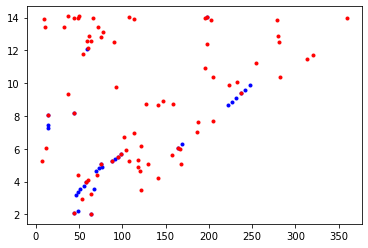

In [158]:
cluster_plot_slice = cluster_centrals_3D[np.logical_and(cluster_centrals_3D.y<=0, cluster_centrals_3D.y>=-25)]
cluster_plot_slice2 = cluster_centrals[np.logical_and(cluster_centrals.y<=-12, cluster_centrals.y>=-16)]
plt.plot(cluster_plot_slice2.x, cluster_plot_slice2.mean_red_z_scaled, ".b")
"""plt.ylim(4, 6)
plt.xlim(70, 80)"""
plt.plot(cluster_plot_slice.x, cluster_plot_slice.mean_red_z_scaled, ".r")
plt.show()

In [ ]:
cluster_centrals_3D

To Do:
4. Plot histogram of (galaxy_redshift - mean_red_of_cluster) where you do this for all clusters
5. Plot histogram of (individual_cluster_redshift - mean_red_of_cluster) where you do this for all clusters

Files:
1. Build a dataframe that contains the center of every tile
2. Using that, choose the 8 nearest tiles, cut off the parts >r away from the edge to current tile and add them to binned_g

Optimize code as much as possible (?)

# Choosing correct value for C
#### Requires returning the median in function

In [29]:
results[40][1][results[40][1].neighbors>=3.5*results[40][2]][['RA', 'DEC','neighbors']].head()

,RA,DEC,neighbors
425,3.725458,-0.952329,39.0
522,8.719883,-3.043524,57.0
154,6.475867,-4.323628,51.0


In [30]:
results[40][1][np.logical_and(results[40][1].neighbors>=3*results[40][2], results[40][1].neighbors<3.5*results[40][2])][['RA', 'DEC', 'neighbors']].head(25)

,RA,DEC,neighbors
73,6.750347,-4.223251,33.0
530,8.655852,-3.026742,38.0
909,1.725383,-0.688769,34.0
637,9.673345,-4.927279,33.0
639,9.692866,-4.931662,34.0
503,8.236548,-1.658904,35.0
691,0.862389,-4.306142,35.0


In [31]:
results[40][1][np.logical_and(results[40][1].neighbors>=2.5*results[40][2], results[40][1].neighbors<3*results[40][2])][['RA', 'DEC', 'neighbors']].head(25)

,RA,DEC,neighbors
438,3.340323,-4.071690,30.0
846,1.780357,-0.709065,28.0
292,7.807836,-0.210069,30.0
202,2.164926,-4.705414,30.0
437,3.310755,-4.098124,29.0
638,9.665872,-4.942027,31.0
46,6.793873,-4.228611,29.0
67,6.511371,-4.264110,31.0
149,6.106854,-0.630238,29.0
256,2.772526,-1.011505,28.0


In [32]:
results[40][1][np.logical_and(results[40][1].neighbors>=2*results[40][2], results[40][1].neighbors<2.5*results[40][2])][['RA', 'DEC', 'neighbors']].head(25)

,RA,DEC,neighbors
777,5.937200,-3.432460,23.0
23,6.157316,-4.539484,22.0
933,1.642744,-0.353180,23.0
22,6.136149,-4.546811,27.0
736,0.569253,-1.548973,22.0
627,9.503089,-2.917561,24.0
836,5.767540,-4.684062,23.0
690,0.836086,-4.325868,24.0
880,1.086536,-3.274483,24.0
320,7.840899,-0.110379,23.0


In [33]:
results[40][1][np.logical_and(results[40][1].neighbors>=1.5*results[40][2], results[40][1].neighbors<2*results[40][2])][['RA', 'DEC', 'neighbors']].sample(25)

,RA,DEC,neighbors
119,6.637784,-1.996886,18.0
277,7.128105,-1.455357,17.0
665,4.027244,-0.308137,17.0
934,1.321781,-1.484976,18.0
822,5.464762,-3.154262,18.0
675,4.347615,-4.175145,18.0
898,1.431657,-1.997010,21.0
26,6.254288,-4.455207,18.0
509,8.991316,-2.649582,19.0
572,9.867243,-2.680981,17.0


# Choosing correct value for R

In [53]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 1.5, C = 2.5)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [54]:
results[40][1][['RA', 'DEC','neighbors']].sample(25)

,RA,DEC,neighbors
312,1.743151,-2.130701,16.0
52,6.136352,-0.654803,21.0
119,7.078596,-2.550223,24.0
281,0.822227,-3.126575,16.0
92,2.891421,-3.928083,17.0
219,8.655743,-1.950261,21.0
124,7.887594,-4.541838,18.0
170,3.264008,-4.342208,19.0
289,5.107213,-2.720071,17.0
113,7.814251,-0.373924,17.0


In [107]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 2, C = 3)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [108]:
results[40][1][['RA', 'DEC','neighbors']].head(25)

,RA,DEC,neighbors
28,3.336221,-4.075040,34.0
29,3.769710,-0.955487,36.0
54,8.655852,-3.026742,38.0
66,9.673345,-4.927279,33.0
1,6.750347,-4.223251,33.0
77,1.725383,-0.688769,34.0
24,3.725458,-0.952329,39.0
62,9.478786,-0.113307,33.0
46,8.719883,-3.043524,57.0
34,8.236548,-1.658904,35.0


In [90]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 2.5, C = 2.5)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [91]:
results[40][1][['RA', 'DEC','neighbors']].head(25)

,RA,DEC,neighbors
33,7.792165,-0.183502,42.0
79,9.637387,-1.533327,41.0
45,3.783597,-0.922071,44.0
75,8.722573,-2.963398,41.0
80,9.673345,-4.927279,44.0
2,6.793873,-4.228611,45.0
31,6.421222,-4.296373,52.0
8,6.511371,-4.264110,50.0
10,6.750347,-4.223251,47.0
77,8.788660,-3.019410,44.0


In [59]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 3, C = 2.5)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [60]:
results[40][1][['RA', 'DEC','neighbors']].head(25)

,RA,DEC,neighbors
69,1.695736,-0.649135,57.0
38,3.752427,-0.936903,58.0
62,8.653258,-2.958986,58.0
11,6.750347,-4.223251,58.0
31,6.421222,-4.296373,72.0
9,6.511371,-4.264110,69.0
64,8.788660,-3.019410,63.0
55,8.655852,-3.026742,78.0
37,3.736976,-0.936550,59.0
6,6.568982,-4.329541,58.0


In [61]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 3.5, C = 2.5)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [62]:
results[40][1][['RA', 'DEC','neighbors']].head(25)

,RA,DEC,neighbors
46,1.695736,-0.649135,83.0
0,6.793873,-4.228611,79.0
43,8.722573,-2.963398,95.0
20,6.421222,-4.296373,84.0
7,6.511371,-4.264110,82.0
44,8.788660,-3.019410,84.0
38,8.655852,-3.026742,92.0
4,6.568982,-4.329541,83.0
30,8.719883,-3.043524,100.0
12,6.475867,-4.323628,84.0


In [63]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 4, C = 2.5)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [64]:
results[40][1][['RA', 'DEC','neighbors']].head(25)

,RA,DEC,neighbors
42,1.695736,-0.649135,99.0
39,8.740076,-2.943072,98.0
31,8.655852,-3.026742,104.0
34,8.658873,-3.017270,108.0
5,6.511371,-4.264110,97.0
40,8.788660,-3.019410,102.0
1,6.568982,-4.329541,105.0
23,8.719883,-3.043524,113.0
9,6.475867,-4.323628,98.0


In [ ]:
cluster.close()
client.shutdown()